# Numerical Exercise 04

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import math
import ipympl

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
names = ["solid", "liquid", "gas"]
files = ["kinetic_energy.dat", "potential_energy.dat", "total_energy.dat", "temperature.dat", "pressure.dat"]



50000
50000
500000
Solid : Initial temperature needed for target temperature 0.8 is 1.54
Check: 0.8
Liquid : Initial temperature needed for target temperature 1.1 is 1.98
Check: 1.1
Gas : Initial temperature needed for target temperature 1.2 is 0.95
Check: 1.2


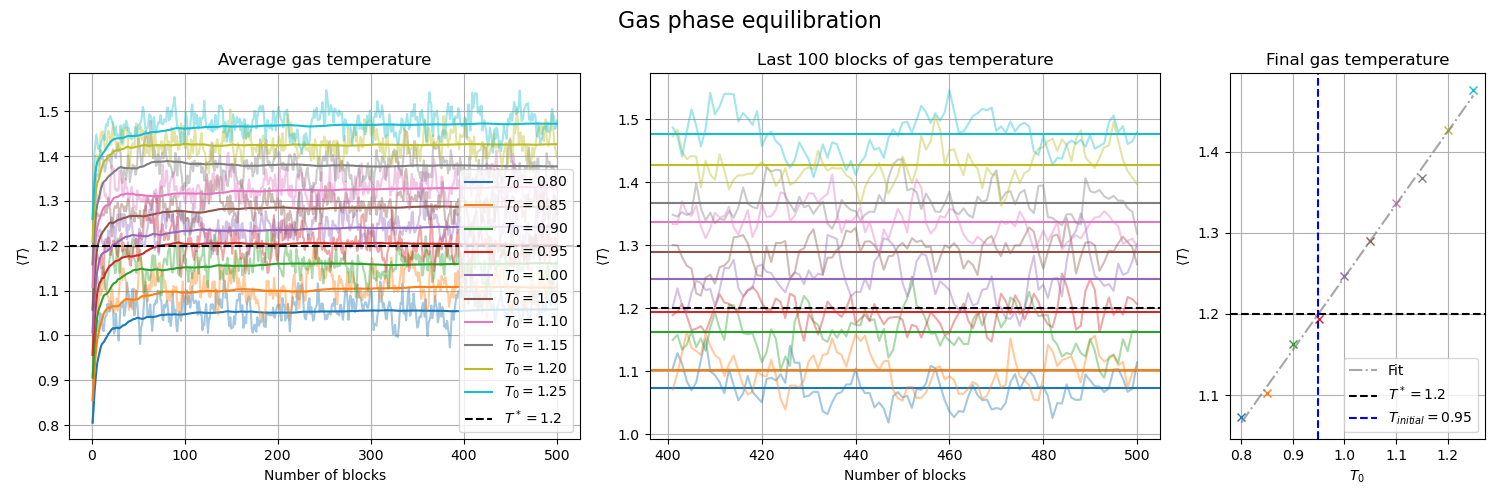

In [2]:

target_temp = [0.8, 1.1, 1.2]
t0 = np.zeros(10)
avgs = np.zeros(10)
last_blocks = [20, 20, 100]
fit_line = []
for name in names:
    gs = gridspec.GridSpec(1, 3, width_ratios=[2,2,1])
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    graphs = [ax1, ax2, ax3]
    fig.suptitle(name.capitalize()+" phase equilibration", fontsize=16)
    for i in range(10):
        starting_temp, n_throws, blck_avg, cum_avg, errors = np.loadtxt("../data/ex04_eq_"+name+"_"+str(i)+".dat", unpack=True, usecols=(0,1,2,3,4))
        label = r"$T_{initial}={temp:.2f}$".format(initial="{0}", temp=starting_temp[1]) 
        t0[i] = starting_temp[1]
        avgs[i] = np.mean(blck_avg[-last_blocks[names.index(name)]:])
        graphs[0].plot(n_throws, blck_avg, color=colors[i] , alpha=0.4)
        graphs[0].plot(n_throws, cum_avg, label=label, color=colors[i])
        graphs[2].plot(t0[i], avgs[i], marker='x')
        graphs[1].plot(n_throws[-last_blocks[names.index(name)]:], blck_avg[-last_blocks[names.index(name)]:], label=label, color=colors[i], alpha=0.4)
        graphs[1].axhline(np.mean(blck_avg[-last_blocks[names.index(name)]:]), label=label, color=colors[i])
    fit_coeffs = np.polyfit(t0, avgs, 1)
    fit_line.append(np.poly1d(fit_coeffs))
    target_label = r"$T^*={temp}$".format(temp=str(target_temp[names.index(name)]))
    graphs[2].plot(t0, fit_line[names.index(name)](t0), color='gray', alpha = 0.7 , linestyle='-.', label="Fit")
    graphs[0].axhline(y=target_temp[names.index(name)], color='black', linestyle='--', label=target_label)
    graphs[1].axhline(y=target_temp[names.index(name)], color='black', linestyle='--', label=target_label)
    graphs[2].axhline(y=target_temp[names.index(name)], color='black', linestyle='--', label=target_label)
    intial_temp = (fit_line[names.index(name)] - target_temp[names.index(name)]).roots
    graphs[2].axvline(x=intial_temp[0], color='b', linestyle='--', label=r"$T_{initial}" + "={temp:.2f}$".format(temp=intial_temp[0]))
    graphs[0].set_title("Average "+name+" temperature")
    graphs[0].set_xlabel('Number of blocks')
    graphs[0].set_ylabel(r"$\langle T \rangle$")
    graphs[0].grid(True)
    graphs[0].legend()
    graphs[2].set_title("Final "+name+" temperature")
    graphs[2].set_xlabel(r"$T_{0}$")
    graphs[2].set_ylabel(r"$\langle T \rangle$")
    graphs[2].grid(True)
    graphs[2].legend()
    graphs[1].set_title("Last {0} blocks of {1} temperature".format(last_blocks[names.index(name)], name))
    graphs[1].set_xlabel('Number of blocks')
    graphs[1].set_ylabel(r"$\langle T \rangle$")
    graphs[1].grid(True)
    plt.tight_layout()

blcks = [100, 100, 500]
steps = [500, 500, 1000]
for b in blcks:
    print(b*steps[blcks.index(b)])

for target in target_temp:
    intial_temp = (fit_line[target_temp.index(target)] - target).roots
    name = names[target_temp.index(target)].capitalize()
    print("{2} : Initial temperature needed for target temperature {0} is {1:.2f}".format(target, intial_temp[0], name))
    print("Check: {0}".format(fit_line[target_temp.index(target)](intial_temp[0])))


plt.show()




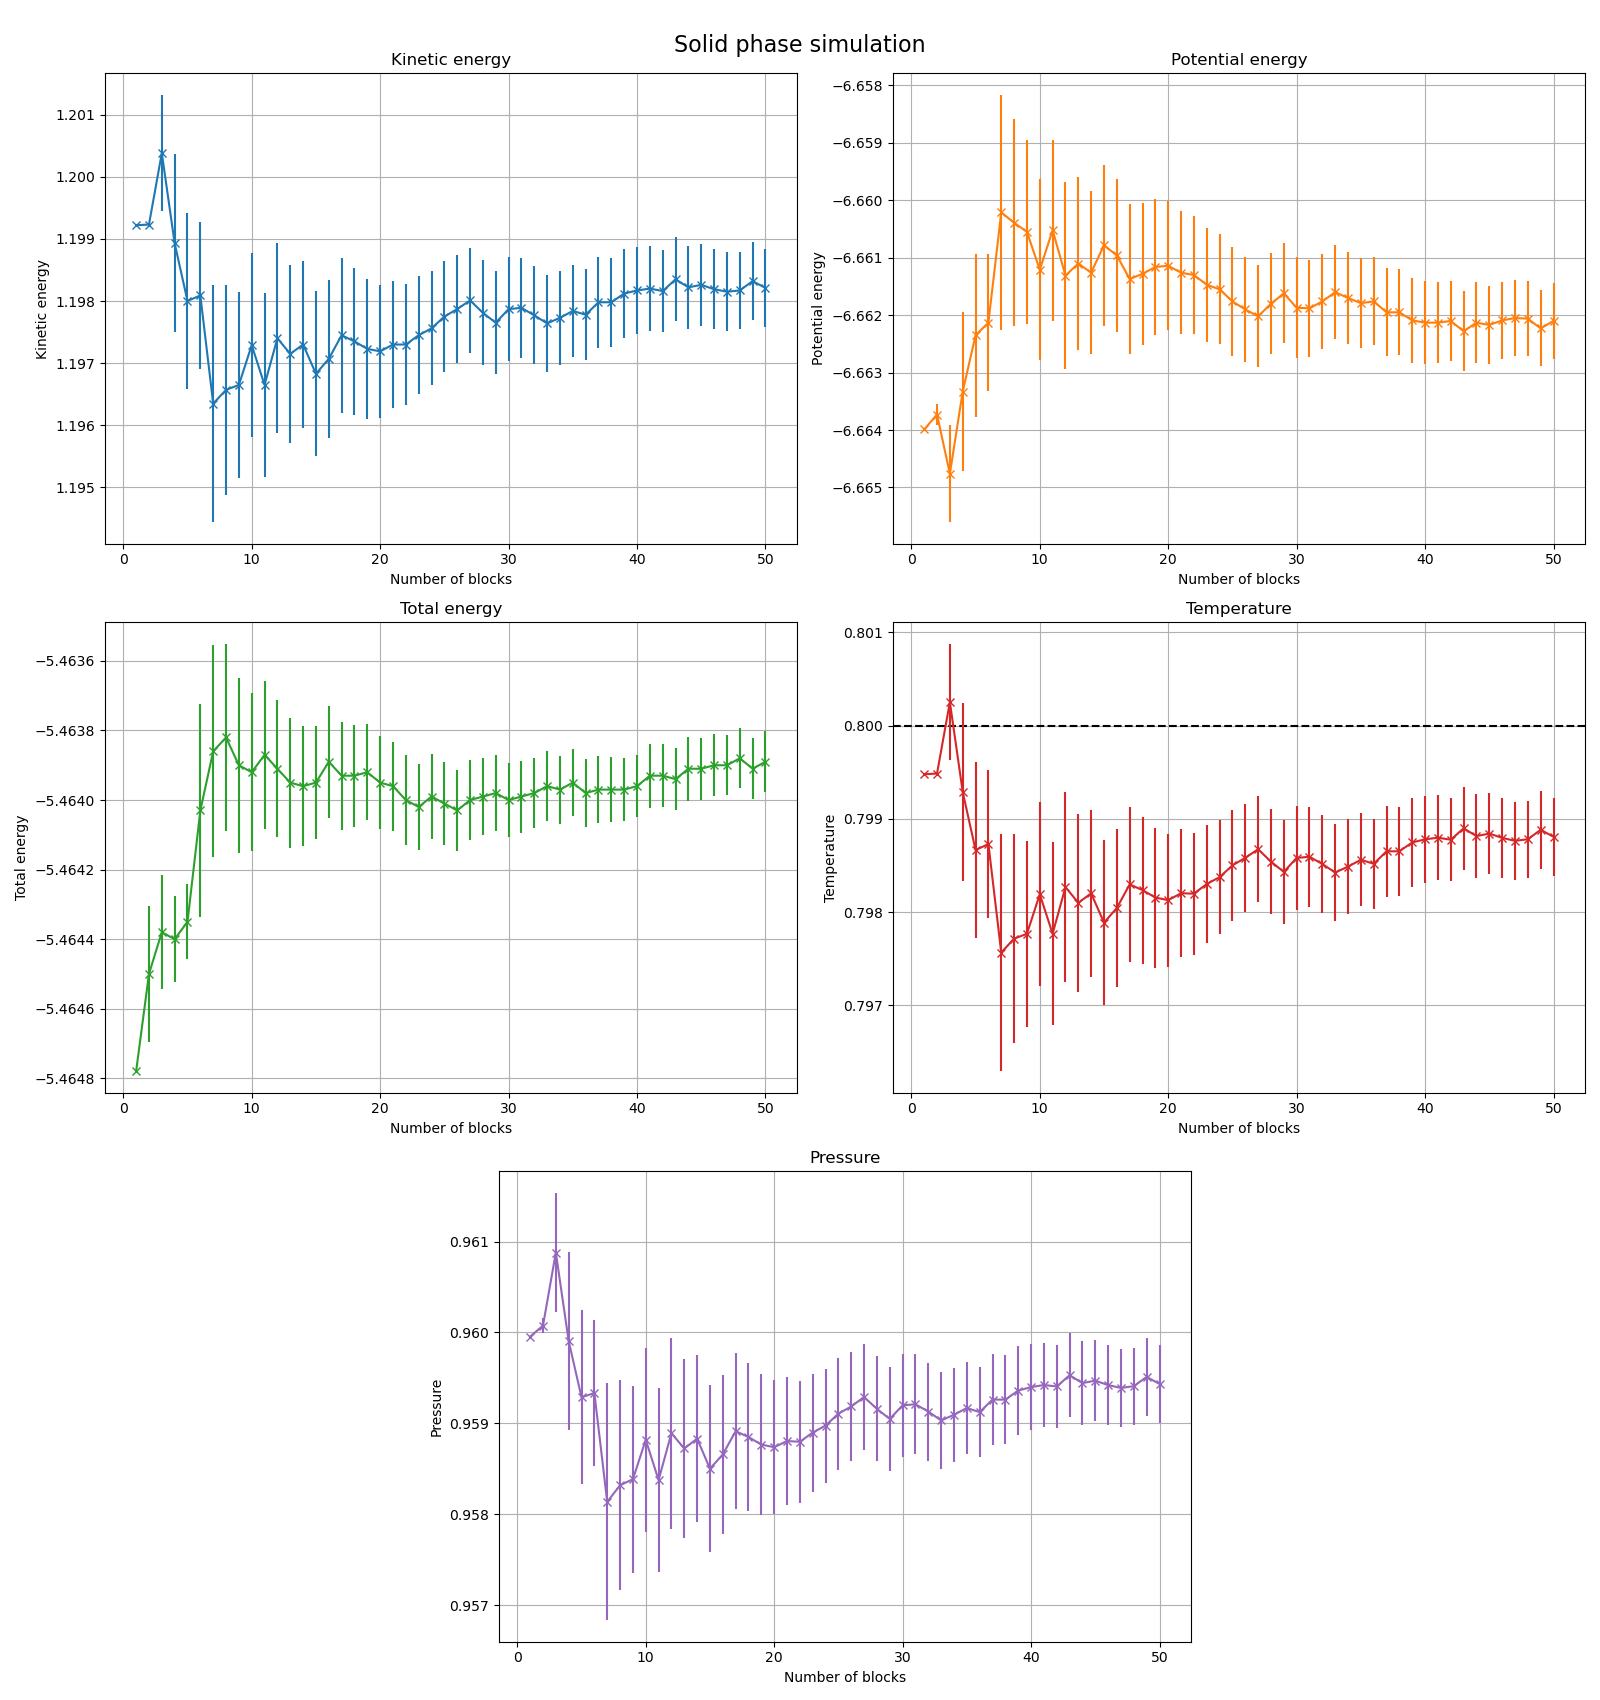

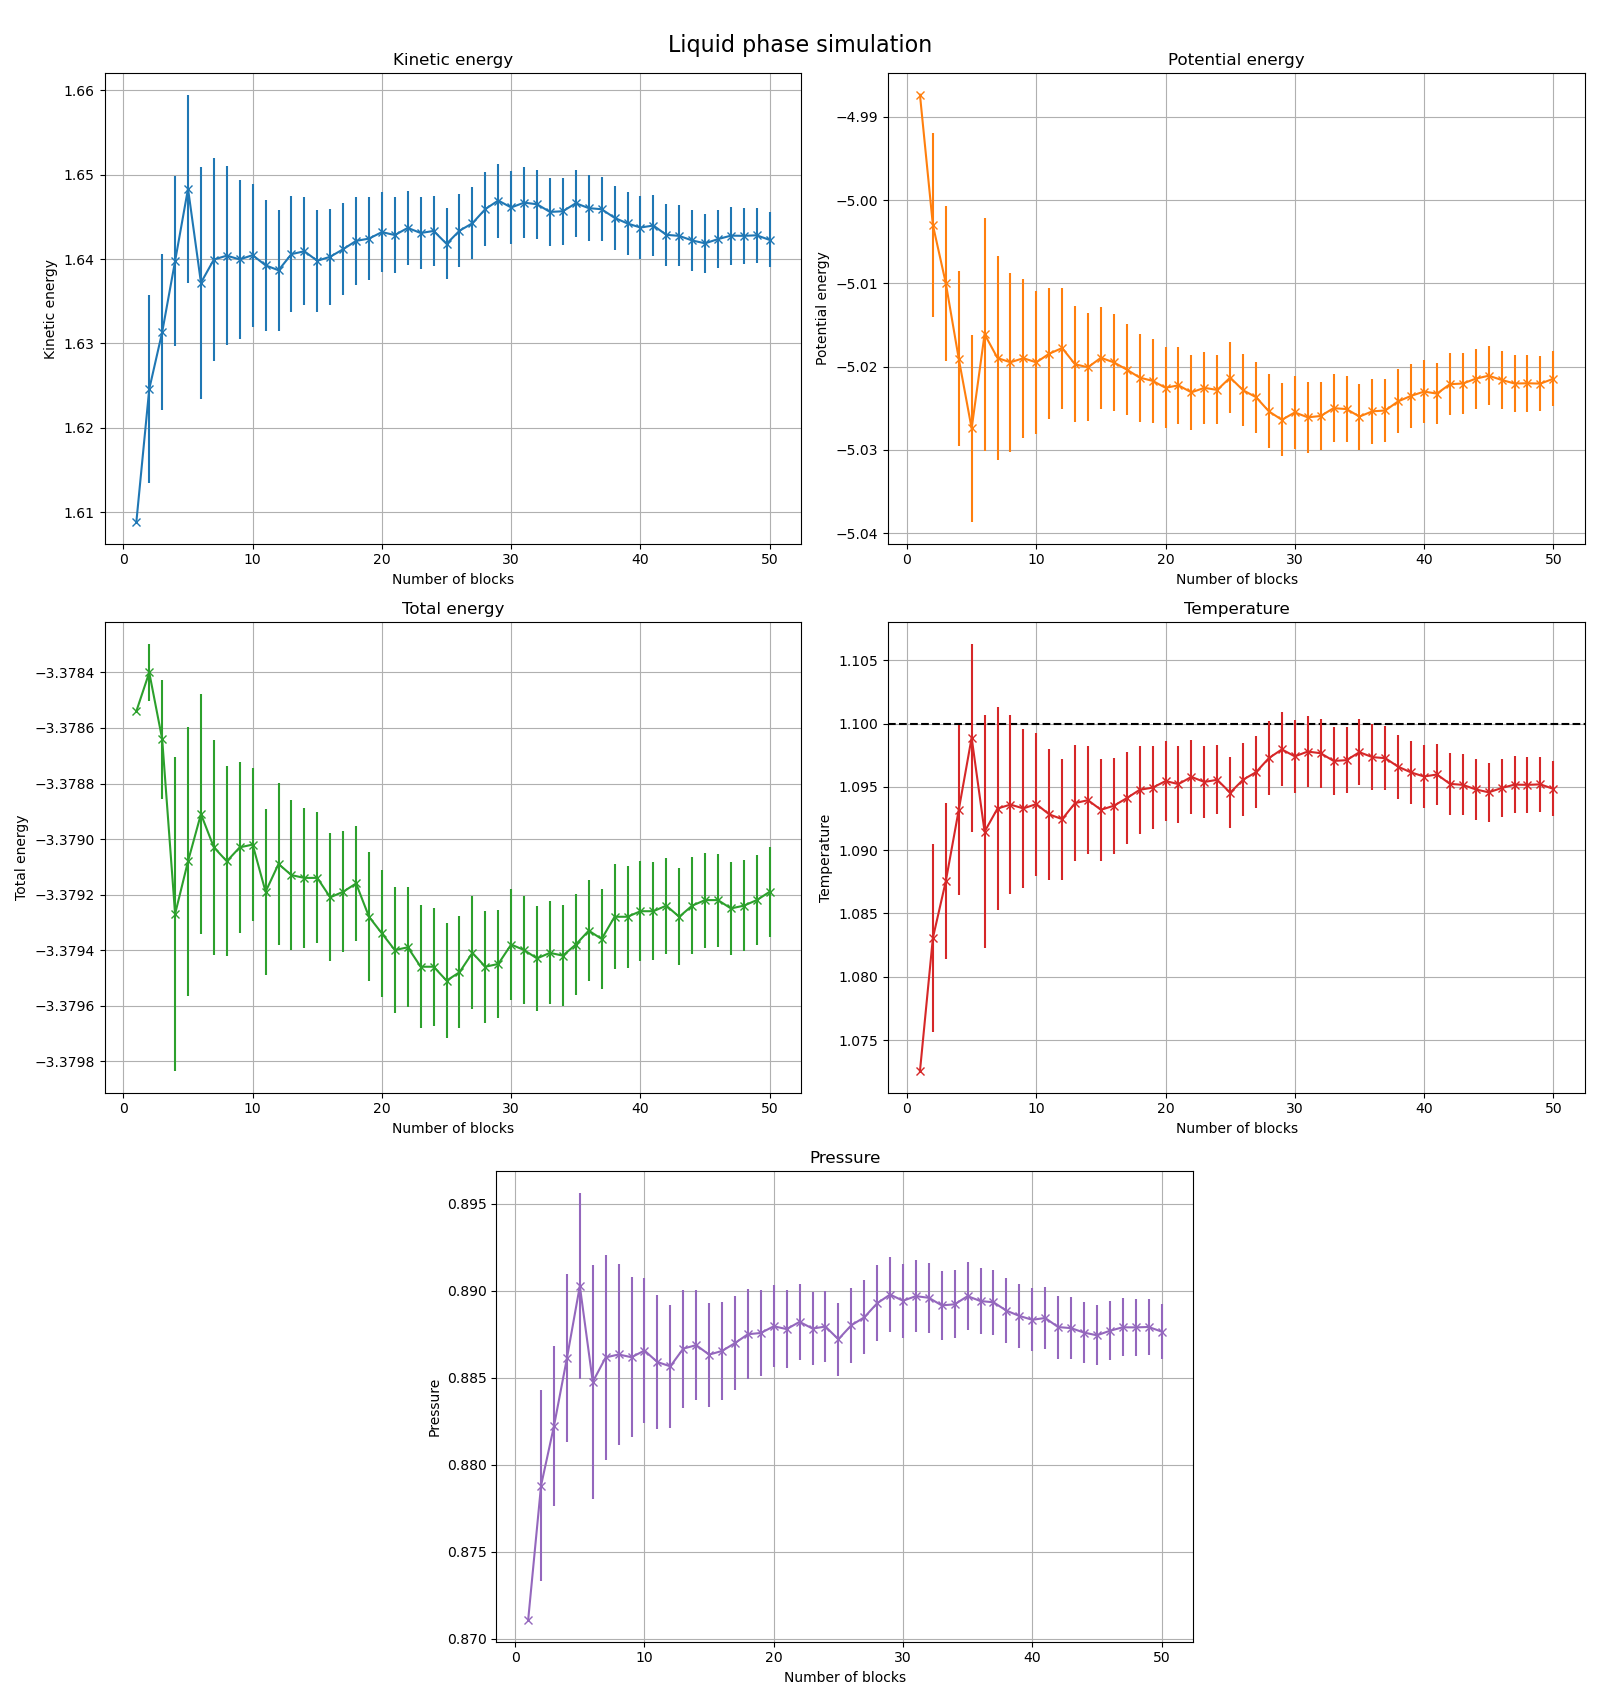

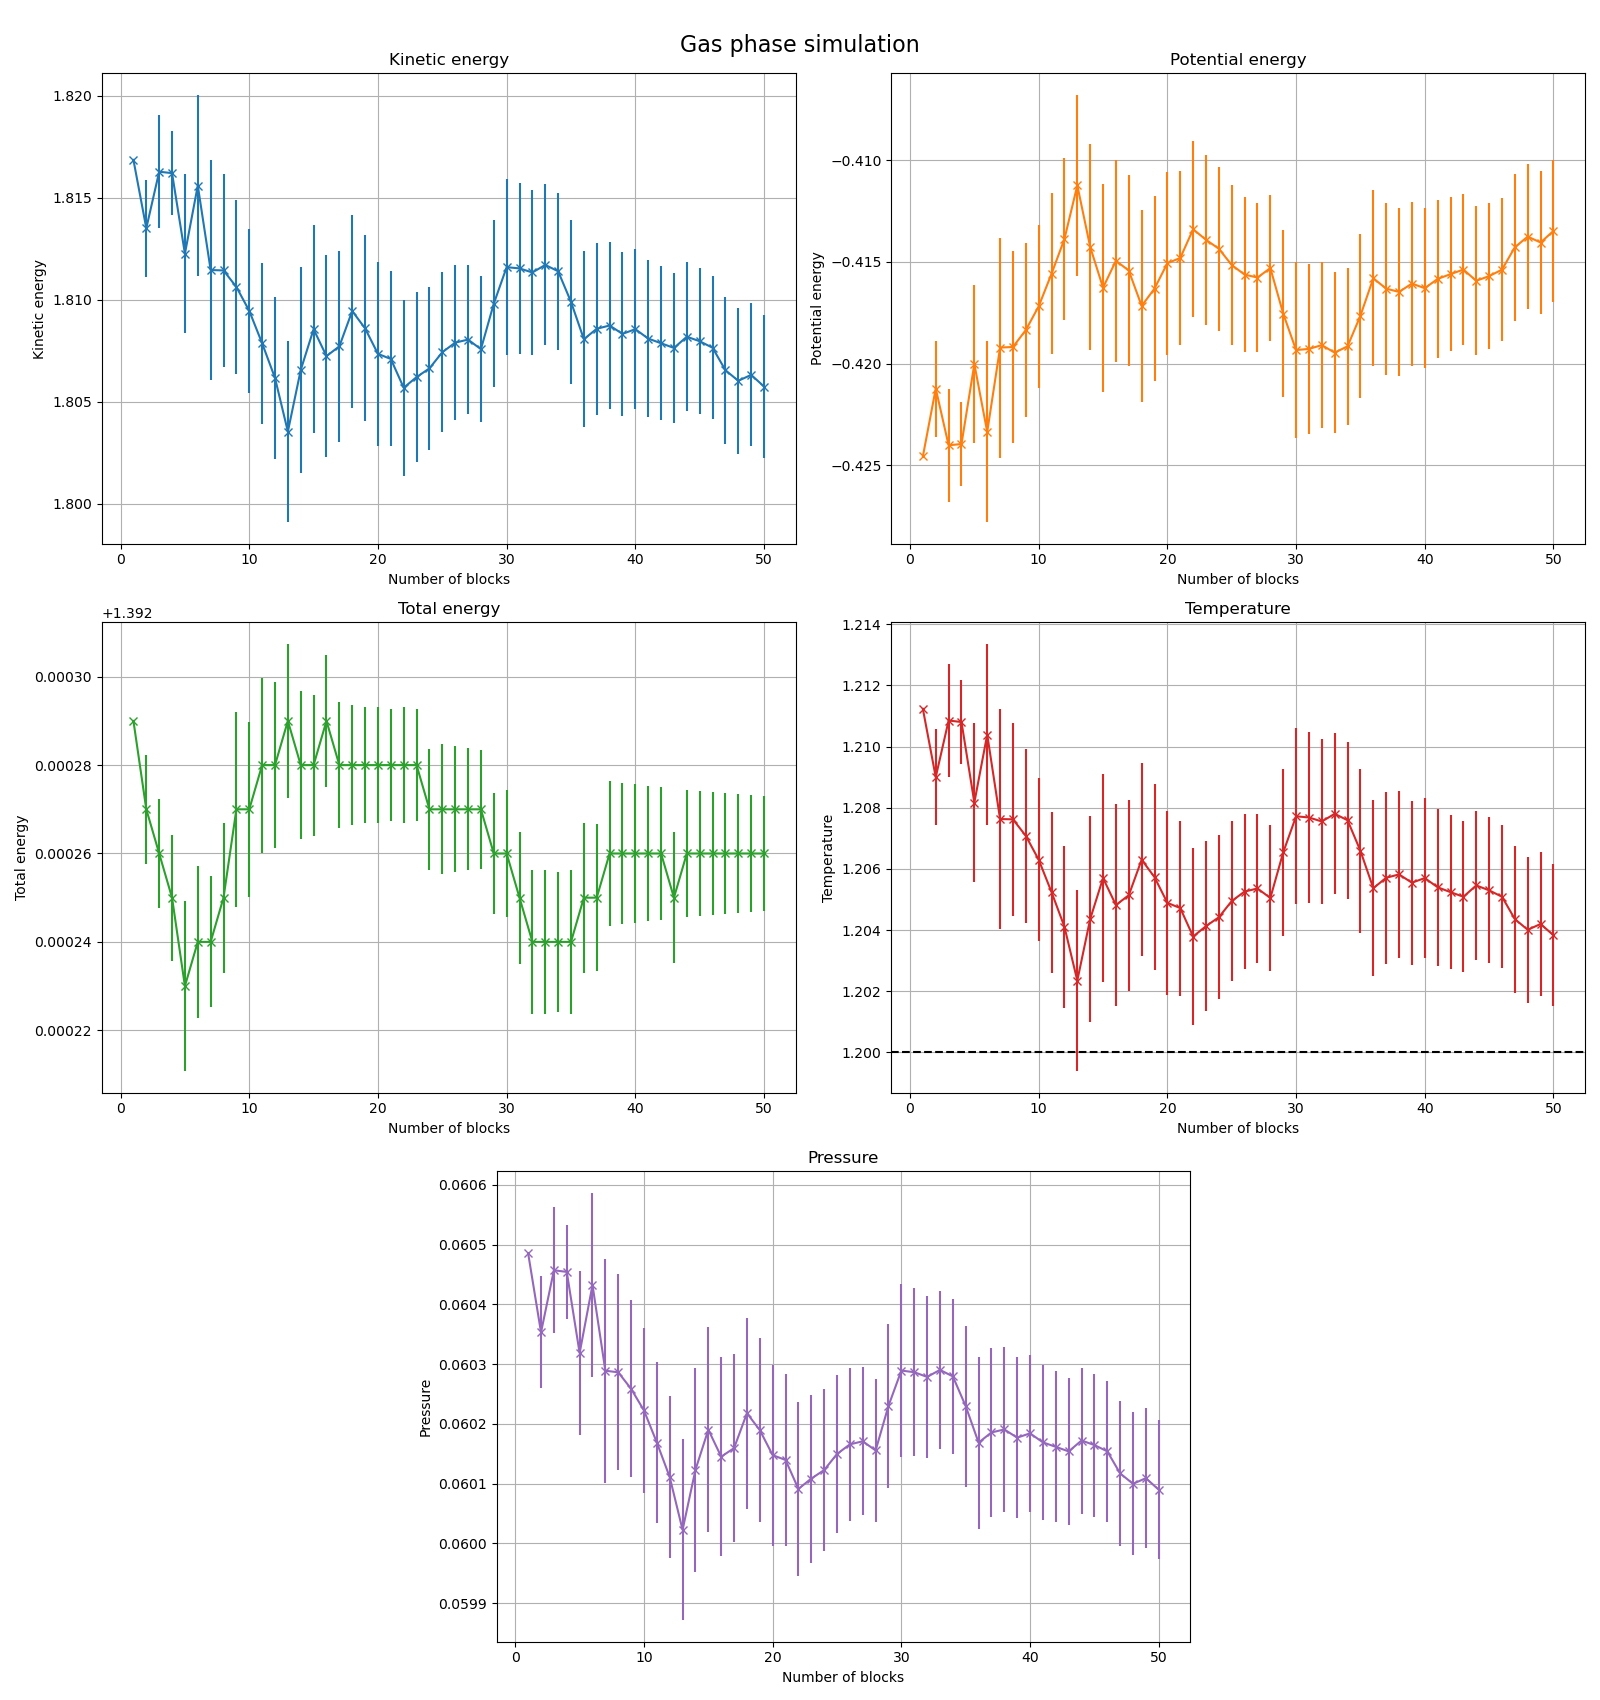

In [3]:
for name in names:
    gs = gridspec.GridSpec(3, 4)
    fig = plt.figure(figsize=(16, 17))
    fig.suptitle(name.capitalize()+" phase simulation", fontsize=16)
    ax1 = fig.add_subplot(gs[0, 0:2])
    ax2 = fig.add_subplot(gs[0, 2:4])
    ax3 = fig.add_subplot(gs[1, 0:2])
    ax4 = fig.add_subplot(gs[1, 2:4])
    ax5 = fig.add_subplot(gs[2, 1:3])
    graphs = [ax1, ax2, ax3, ax4, ax5]
    graphs[3].axhline(y=target_temp[names.index(name)], color='black', linestyle='--', label="Target temperature")
    basefilename = "../data/ex04/OUTPUT_"+name.upper()
    for i, file in enumerate(files):
        n_blck, actual, avg, error = np.loadtxt(basefilename+"/"+file, unpack=True, usecols=(0,1,2,3), skiprows=1)
        label = ((file.split('.')[0]).replace('_', ' ')).capitalize()
        graphs[i].errorbar(n_blck, avg, yerr=error, label=label, color=colors[i], marker='x')
        graphs[i].set_title(label)
        graphs[i].set_xlabel('Number of blocks')
        graphs[i].set_ylabel(label)
        graphs[i].grid(True)
    plt.tight_layout()
    plt.show()



In [4]:
for name in names:
    gs = gridspec.GridSpec(3, 4)
    fig = plt.figure(figsize=(16, 17))
    fig.suptitle(name.capitalize()+" phase simulation", fontsize=16)
    ax1 = fig.add_subplot(gs[0, 0:2])
    ax2 = fig.add_subplot(gs[0, 2:4])
    ax3 = fig.add_subplot(gs[1, 0:2])
    ax4 = fig.add_subplot(gs[1, 2:4])
    ax5 = fig.add_subplot(gs[2, 1:3])
    graphs = [ax1, ax2, ax3, ax4, ax5]
    graphs[3].axhline(y=target_temp[names.index(name)], color='black', linestyle='--', label="Target temperature")
    basefilename = "../data/ex04/OUTPUT_EQ_"+name.upper()
    for i, file in enumerate(files):
        n_blck, actual, avg, error = np.loadtxt(basefilename+"/"+file, unpack=True, usecols=(0,1,2,3), skiprows=1)
        label = ((file.split('.')[0]).replace('_', ' ')).capitalize()
        graphs[i].errorbar(n_blck, avg, yerr=error, label=label, color=colors[i], marker='x')
        graphs[i].set_title(label)
        graphs[i].set_xlabel('Number of blocks')
        graphs[i].set_ylabel(label)
        graphs[i].grid(True)
    plt.tight_layout()
    plt.show()


FileNotFoundError: ../data/ex04/OUTPUT_EQ_SOLID/kinetic_energy.dat not found.

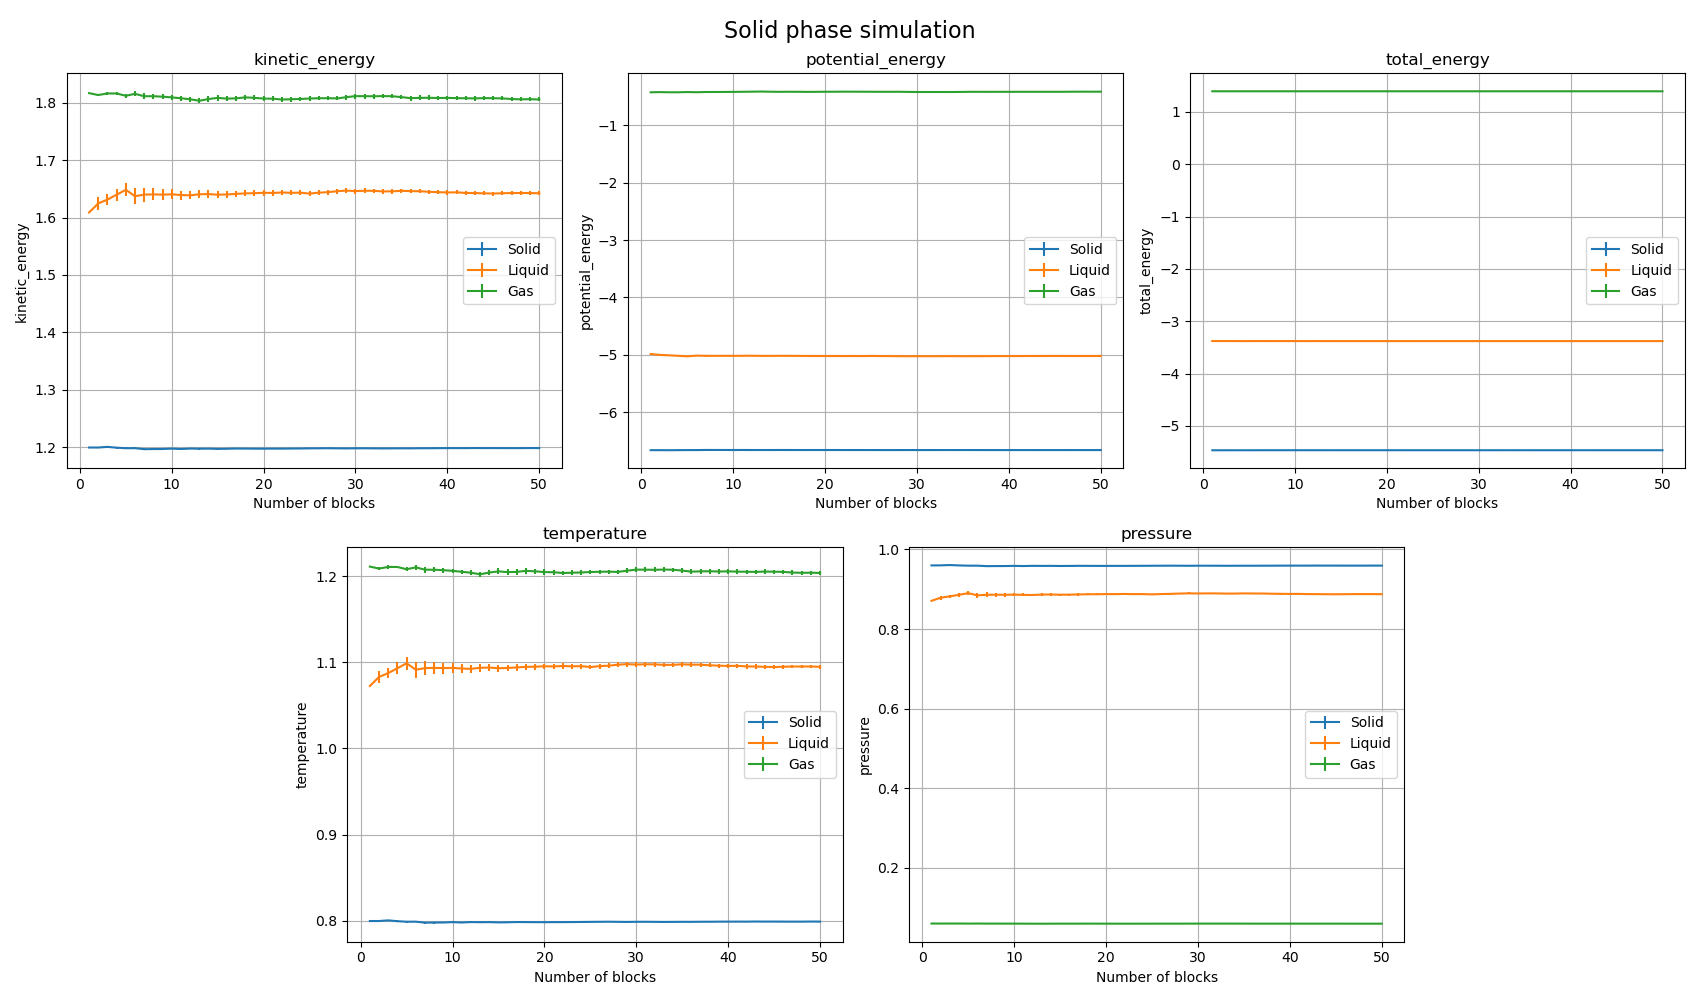

In [5]:

gs = gridspec.GridSpec(2, 6)
fig = plt.figure(figsize=(17, 10))
fig.suptitle(name.capitalize()+" phase simulation", fontsize=16)
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])
ax4 = fig.add_subplot(gs[1, 1:3])
ax5 = fig.add_subplot(gs[1, 3:5])
graphs = [ax1, ax2, ax3, ax4, ax5]

for i, file in enumerate(files):
    for j, name in enumerate(names):
        basefilename = "../data/ex04/OUTPUT_"+name.upper()
        n_blck, actual, avg, error = np.loadtxt(basefilename+"/"+file, unpack=True, usecols=(0,1,2,3), skiprows=1)
        graphs[i].errorbar(n_blck, avg, yerr=error, label=name.capitalize(), color=colors[j])
        graphs[i].set_title(file.split('.')[0])
        graphs[i].set_xlabel('Number of blocks')
        graphs[i].set_ylabel(file.split('.')[0])
        graphs[i].grid(True)
    graphs[i].legend()
plt.tight_layout()
plt.show()

